In [2]:
# Choose a random number of 6 digits. Make sure that you keep a copy of this number and avoid trivial numbers, such as 000000 or 123456 -- thank you!
292701

292701

# Assignment 1 - Visualisation and Performance Evaluation

First assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados 

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* The notebook already imports all the necessary libraries for this assignment at the beginning. Although you are allowed to import other libraries, it is not necessary.
* Before submitting your work, make sure to rename the file to your random number that you created above (for example, 289479.ipynb).

## Notebook Overview:

1. [Data Loading and Visualisation](#Data-Loading-and-Visualisation) (20%)
2. [Binary Classification Building a PR curve](#Binary-Classification-Building-a-PR-curve) (50%)
3. [Regression RMSE](#Regression-RMSE) (30%)

In [3]:
%matplotlib inline
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score

## Data Loading and Visualisation

* Load the Iris dataset that you downloaded from the following link: https://www.kaggle.com/datasets/uciml/iris/download?datasetVersionNumber=2
* __Important:__ to ensure proper execution of your code, you need to either place the downloaded .csv file in the same working directory as the program or specify the correct path to the file.
* Load the data into a pandas `DataFrame`
* For each feature in the dataset, create a figure with two subplots one on top of the other.
    * In the first subplot, plot a vertical boxplot of the values of the feature for all classes combined. 
    * In the second subplot, plot a vertical boxplot of the values of the feature for each class separately. Use the column “Species” as the class identifier, and a different color for each class. 
    

* __Note:__ the data contains a column "Id" that you can ignore. 

In [4]:
# Load the data
# your code goes here
data_path = "./dados/Iris.csv"
iris_data = pd.read_csv(data_path)
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


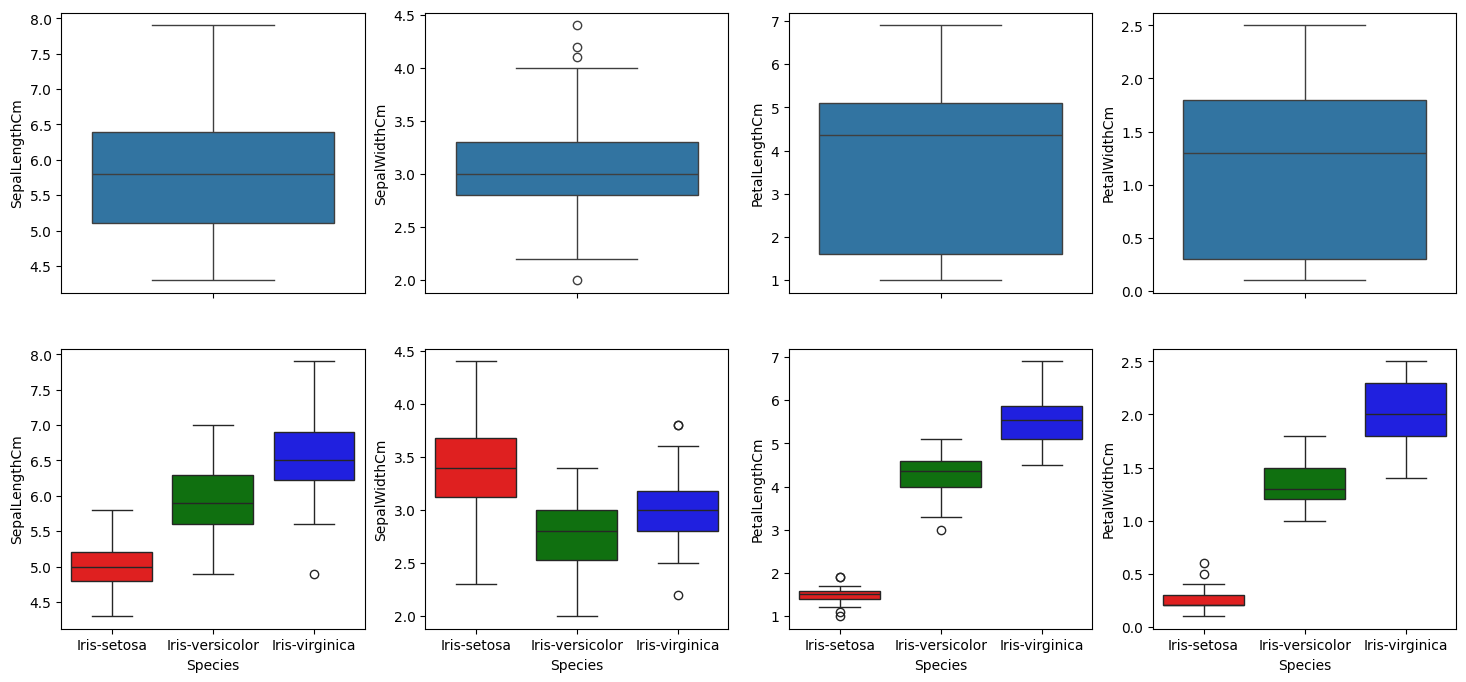

In [5]:
# The code for your plots go here
features = list(iris_data.columns[1:-1])
cores = ["red", "green", "blue"]

fig, axs = plt.subplots(2, 4, figsize=(18, 8))

for j in range(len(features)):
    feature = features[j]

    sns.boxplot(data=iris_data, y=feature, ax=axs[0,j])
    sns.boxplot(data=iris_data, y=feature, x="Species", ax=axs[1,j],
                palette=cores, hue="Species")

## Binary Classification Building a PR curve

The goal of this exercise is to evaluate the performance of various pre-trained classification models in predicting whether a mushroom is edible or poisonous. To achieve this, we will generate PR curves for each algorithm and determine the area under the curve. Using these metrics, we will decide which classifier is best suited for the task.

Follow the instructions in the cells below to complete this task.

In [6]:
# Loading the pre-trained classifiers and testing data
classifiers = pkl.load(open('classifiers_dict.p','rb'))
mushroom_test_data = pkl.load(open('mushroom_test_data.p','rb'))

The loaded variables are dictionaries. One contains the pre-trained classifiers and the other one the testing data. 

Let's inspect the contents of the classifiers_dict

In [3]:
classifiers

{'Categorical NB': CategoricalNB(),
 'Logistic Regression': LogisticRegression(max_iter=600),
 'SVM': SVC(probability=True)}

* We can see that the key is the name of the classifier and the value contains the pre-trained instance of each classifier. 
* In the next code cell there's code to extract the classifiers into separate variables.

In [4]:
cnb_clf = classifiers['Categorical NB']
lr_clf = classifiers['Logistic Regression']
svm_clf = classifiers['SVM']

Next we'll extract the testing data from the mushroom_test_data dictionary we just loaded.

First, let's inspect the keys of the dictionary (we don't look at the values because the data is rather large and we don't want it to take up the whole screen).

In [5]:
mushroom_test_data.keys()

dict_keys(['X_test', 'y_test'])

* X_test contains the data points with their features that will serve as the input to our trained models.
* y_test contains the true labels for the testing set, which we'll use to evaluate our predictions.

In [6]:
X_test = mushroom_test_data['X_test']
y_test = mushroom_test_data['y_test']

As we can see below, X_test contains the 21 features that were used to train the different classifiers. 
* __Note__ that the index is shuffled because this is a random subset of the original data that we are using as our testing set.

In [7]:
X_test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
700,5,2,4,1,6,1,0,1,10,0,...,2,2,7,7,2,1,4,2,3,1
6743,2,2,2,0,8,1,0,1,0,1,...,1,2,6,6,2,1,0,7,4,0
1571,5,0,8,0,5,1,1,0,4,1,...,2,0,7,7,2,1,0,2,0,1
5949,5,3,4,0,5,1,1,1,10,0,...,0,2,7,4,2,1,0,7,4,2
3307,2,3,4,1,5,1,0,0,5,1,...,2,2,7,6,2,1,4,3,5,0


During class we looked at the case where the output of the classifier is a number between 0 and 1. This is the case for the classifiers we will use here. For these classifiers this output can be interpreted as the probabilities.

We are now going to obtain the predicted probabilities from our different classifiers
* To do this we are using the method `predict_proba()`
* This is a method specific to each classifier and it requires as input argument the datapoints of our testing set with their features (`X_test`).

In [8]:
y_proba_cnb = cnb_clf.predict_proba(X_test)
y_proba_svm = svm_clf.predict_proba(X_test)
y_proba_lr = lr_clf.predict_proba(X_test)

Let's inspect one of the variables we just created. 

We notice that it contains two values per row that sum up to 1. The first value is the probability of class 0 and the second value is the probability of class 1.

__For this exercise, you will use only the second column (probability of class 1) as was explained in class.__

In [9]:
y_proba_cnb

array([[0.54287323, 0.45712677],
       [0.29988335, 0.70011665],
       [0.67251778, 0.32748222],
       ...,
       [0.67880951, 0.32119049],
       [0.69545763, 0.30454237],
       [0.64476354, 0.35523646]])

## Calculating the precision and recall
Now that we have our predicted values and the true labels, we are ready to generate the PR curve

Feel free to define the function(s) in a way that you find most comfortable. The goal of these functions is to generate the precision and recall at different thresholds for all classifiers.

The cell below contains a suggestion on how you can structure the function -- you can also do it differently if you prefer.

In [ ]:
# The following is just example code, it is not meant to be executed.
def get_precision_recall(predicted_values, true_labels, threshold):
    # body of the function
    return precision, recall
# this function would calculate the confusion matrix and then the precision and recall to return it as two separate values. 

# to then use the output values of this function you would do something like:
precision, recall = get_precision_recall(y_proba_lr, y_test, threshold)

In [ ]:
# Your code goes here!!



## Plotting the PR curve
Now let's use the calculated precisions and recalls to plot the PR curves for the different classifiers.

The template below provides the typical structure of a superimposed plot, but you're welcome to modify it to fit your needs.

In [ ]:
# Here you must complete the calls to plt.plot() with the right input arguments
# Following that you will need to generate the correct plot properties below
fig = plt.figure(figsize=(8,6))
# PR Curve for the Categorical Naive Bayes
plt.plot()
# PR Curve for Logistic Regression
plt.plot()
# PR Curve for SVM
plt.plot()


# Plot properties
# Title

# X-Ticks and X-label 

# Y-Ticks and Y-label

# Legend

plt.show()

## BONUS (10% extra marks)
You get bouns points if you make the plot using a single call to a plotting function.
* _Tip: use pandas and seaborn for this_

In [ ]:
# Your code goes here



## Area under the curve
You are not expected to code a function to calculate the area under the PR curve. Instead you have to use the provided function: `average_precision_score()` to obtain this value. 

_Make sure to check the relevant documentation for this sklearn function._
* __Important: remember that we only care about the second column of our predicted probabilities!__

In [ ]:
# Fill in your code where necessary
cnb_auprc = # your code goes here
print("The AUPRC for the Categorical Naive Bayes classifier is: {}".format(cnb_auprc))
svm_auprc = # your code goes here
print("The AUPRC for the SVM classifier is: {}".format(svm_auprc))
lr_auprc = # your code goes here
print("The AUPRC for the Logistic Regression classifier is: {}".format(lr_auprc))

After analyzing the PR curves and calculating the area under the curves, it should be apparent that the Categorical Naive Bayes classifier outperforms the other classifiers and is the most suitable option for this particular problem.

## Regression RMSE

The final exercise of this coursework requires you to calculate the Root Mean Squared Error (RMSE) of a linear regression model that predicts house prices.

In [10]:
# Load the data and the pre-trained model
boston_testing_data = pkl.load(open('boston_testing_data.p','rb'))
linear_regression_model = pkl.load(open('linear_regression_model.p','rb'))

Again, we extract the testing features and the true values in separate variables. 
* __Important:__ I use different variable names because X_test and y_test are being used for exercise 2. There's no need for this, but just to avoid confusion and to not step on pre-existing variables

In [11]:
X_test_boston = boston_testing_data['X_test']
y_test_boston = boston_testing_data['y_test']

Let's now obtain the predicted values

In [12]:
y_predict_lin_reg = linear_regression_model.predict(X_test_boston)

## Calculating RMSE
Now you have to write code to calculate the root mean squared error on the testing set for the linear regression model we just loaded.
At the end, just print the RMSE value for verification.

In [ ]:
# Your code goes here



## BONUS (5% extra marks)
You get this bonus marks if you are able to calculate the RMSE by vectorising your code, that is, no loops whatsoever.

In [ ]:
# Your code for the bonus marks goes here

